# Определение перспективного тарифа для телеком-компании

## Содержание проекта
2. [Описание проекта](#1)
3. [Предобработка данных](#2)
* [Вывод](#2.1)
4. [Расчет метрик](#3)
* [Вывод](#3.1)
5. [Анализ данных](#4)
* [Вывод](#4.1)
6. [Проверка гипотез](#5)
* [Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются](#5.1)
* [Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.](#5.2)
7. [Общий вывод](#6)
* [Рекомендации компании](#6.1)    

##  Описание проекта <a id="1"></a> 

Заказчик: федеральный оператор сотовой связи.  

**Исходные данные** - выборка данных пользователей за 2018 год.  

**Цель проекта** - на основе анализа данных, посчитанных метрик и созданных графиков оценить, какой тариф является более прибыльным для компании.  

**Задачи**  
- Провести предобработку данных (пропуски, дубликаты, типы данных и т.д.)  
- Провести анализ данных (посчитать среднее количество, дисперсию и стандартное отклонение, построить гистограммы, описать распределение)  
- Проверить гипотезы несколькими критериями  
- Описать общий вывод


**Описание тарифов**  
1) Тариф «Смарт»:  
- Ежемесячная плата: 550 рублей  
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика  
- Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.  

2) Тариф «Ультра»:  
- Ежемесячная плата: 1950 рублей  
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика  
- Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.  

**Описание данных**  

**Таблица users (информация о пользователях):**  
- user_id — уникальный идентификатор пользователя  
- first_name — имя пользователя  
- last_name — фамилия пользователя  
- age — возраст пользователя (годы)  
- reg_date — дата подключения тарифа (день, месяц, год)  
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)  
- city — город проживания пользователя  
- tarif — название тарифного плана  

**Таблица calls (информация о звонках):**  
- id — уникальный номер звонка  
- call_date — дата звонка  
- duration — длительность звонка в минутах  
- user_id — идентификатор пользователя, сделавшего звонок  

**Таблица messages (информация о сообщениях):**  
- id — уникальный номер сообщения  
- message_date — дата сообщения  
- user_id — идентификатор пользователя, отправившего сообщение  

**Таблица internet (информация об интернет-сессиях):**  
- id — уникальный номер сессии  
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)  
- session_date — дата интернет-сессии  
- user_id — идентификатор пользователя 

**Таблица tariffs (информация о тарифах):**
- tariff_name — название тарифа  
- rub_monthly_fee — ежемесячная абонентская плата в рублях  
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату  
- messages_included — количество сообщений в месяц, включённых в абонентскую плату  
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)  
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)  
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета  
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)  

##  Предобработка данных  <a id="2"></a> 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore') #отключим всплывающие предупреждения питона
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import math
from scipy import stats as st

In [2]:
def first_look (df):
    '''Функция получения первичной информации о датафрейме'''
    print ('------------- Первые 5 строк ------------')
    display(df.head())
    print('')
    print('')
    print ('------------- Типы данных ------------')
    print (df.info())
    print('')
    print('')
    print ('------------- Пропуски ------------')
    count = 0
    for element in df.columns:
        if df[element].isna().sum() > 0:
            print(element, ' - ', df[element].isna().sum(), 'пропусков')
            count = +1
        if count == 0:
            print('Пропусков НЕТ')
    print('')
    print('')
    print('--------------Дубликаты--------------')
    print(df.duplicated().sum(), 'дубликатов')


In [3]:
calls, internet, messages,tariffs, users = (
    pd.read_csv('https://code.s3.yandex.net/datasets/calls.csv'),  # журнал звонков
    pd.read_csv('https://code.s3.yandex.net/datasets/internet.csv'),  # интернет-сессии
    pd.read_csv('https://code.s3.yandex.net/datasets/messages.csv'),  # сообщения
    pd.read_csv('https://code.s3.yandex.net/datasets/tariffs.csv'),  # тарифы
    pd.read_csv('https://code.s3.yandex.net/datasets/users.csv'),  # пользователи
)

In [4]:
data_list=[calls, internet, messages,tariffs, users]
for data in data_list:
    first_look(data)

------------- Первые 5 строк ------------


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None


------------- Пропуски ------------
Пропусков НЕТ
Пропусков НЕТ
Пропусков НЕТ
Пропусков НЕТ


--------------Дубликаты--------------
0 дубликатов
------------- Первые 5 строк ------------


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None


------------- Пропуски ------------
Пропусков НЕТ
Пропусков НЕТ
Пропусков НЕТ
Пропусков НЕТ
Пропусков НЕТ


--------------Дубликаты--------------
0 дубликатов
------------- Первые 5 строк ------------


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None


------------- Пропуски ------------
Пропусков НЕТ
Пропусков НЕТ
Пропусков НЕТ


--------------Дубликаты--------------
0 дубликатов
------------- Первые 5 строк ------------


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None


------------- Пропуски ------------
Пропусков НЕТ
Пропусков НЕТ
Пропусков НЕТ
Пропусков НЕТ
Пропусков НЕТ
Пропусков НЕТ
Пропусков НЕТ
Пропусков НЕТ


--------------Дубликаты--------------
0 дубликатов
------------- Первые 5 строк ------------


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


------------- Пропуски ------------
Пропусков НЕТ
Пропусков НЕТ
churn_date  -  462 пропусков


--------------Дубликаты--------------
0 дубликатов


Пропуски имеются только в столбце churn_date, но это означает,что тариф ещё действовал на момент выгрузки данных.

In [5]:
#приведем столбцы, содержащие дату к нужному формату:
time_format = '%Y-%m-%d'
calls['call_date'] = pd.to_datetime(calls['call_date'], format = time_format)
internet['session_date']= pd.to_datetime(internet['session_date'], format = time_format)
messages['message_date']= pd.to_datetime(messages['message_date'], format = time_format)
users['reg_date'] = pd.to_datetime(users['reg_date'], format = time_format)
users['churn_date'] = pd.to_datetime(users['churn_date'], format = time_format)

In [6]:
#Unnamed: 0 не несет никакой информации, удаляем его
internet = internet.drop(columns = ['Unnamed: 0'])

Имеется важное примечание:
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.
Округлим данные столбцов, содержащих информацию о продолжительности звонков и объеме интернета, согласно данному примечанию и приведем к формату int

In [7]:
calls['duration']=calls['duration'].apply(pd.np.ceil)
calls['duration']=calls['duration'].astype('int')
internet['mb_used']=internet['mb_used'].apply(pd.np.ceil)
internet['mb_used']=internet['mb_used'].astype('int')

In [8]:
# построим гистограмму и ящик с усами для числовых столбцов
def hist_boxplot(df,column):
    df[column].hist()
    plt.ylabel('Количество')
    plt.xlabel('Длительность')
    plt.title('Гистограмма распределения')
    plt.show()
    df.boxplot(column)
    plt.xlabel('Количество')
    plt.ylabel('Длительность')
    plt.title('Ящик с усами')
    plt.show()

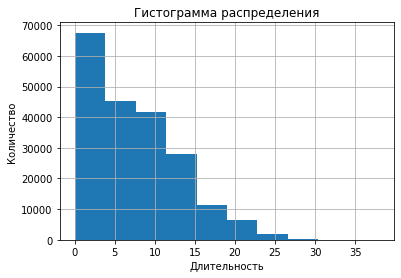

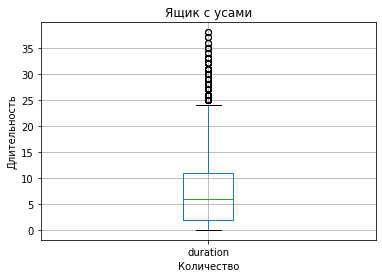

In [9]:
hist_boxplot(calls,'duration')

In [10]:
#посмотрим, сколько значений находится за пределами верхнего уса
display((calls['duration'] > 24).sum())

1041

In [11]:
#вычисляем предел усов
def boxplot_quantile(df,column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    mistash_down = q1 - 1.5 * iqr
    mistash_up = q3 + 1.5 * iqr
    print('Нижний ус = ', mistash_down)
    print('Верхний ус = ', mistash_up)
    print('Сколько выше верхнего уса - ', (df[column] > mistash_up).sum())
    print('Процент значений выше верхнего уса - ', ((df[column] > mistash_up).sum()/ df[column].count()*100),'%')
    print('Процент значений ниже нижнего уса - ', ((df[column] > mistash_down).sum()/ df[column].count()*100),'%')

In [12]:
boxplot_quantile(calls,'duration')

Нижний ус =  -11.5
Верхний ус =  24.5
Сколько выше верхнего уса -  1041
Процент значений выше верхнего уса -  0.5138025833263411 %
Процент значений ниже нижнего уса -  100.0 %


Выбросов меньше 1% - оставим так как есть. Аналогично посмотрим распределение для других столбцов.

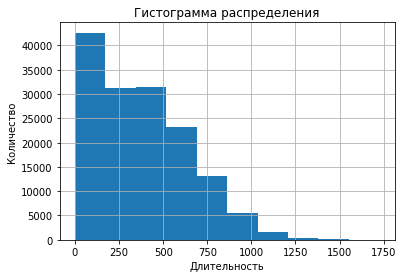

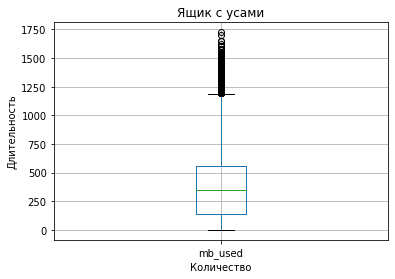

In [13]:
hist_boxplot(internet,'mb_used')

In [14]:
boxplot_quantile(internet,'mb_used')

Нижний ус =  -492.5
Верхний ус =  1191.5
Сколько выше верхнего уса -  547
Процент значений выше верхнего уса -  0.366140994404134 %
Процент значений ниже нижнего уса -  100.0 %


### Вывод: <a id="2.1"></a> 

Предобработка завершена.Данные приведены к нужному формату, удален ненужный столбец,дубликаты не найдены, пропуски в столбце churn_date допустимы согласно условию, выбросы не удалены,так как они составляют менее 1 % от всех данных, распределение данных, судя по диаграммам, соответствуют распределению Пуассона, что является нормальным.

## Расчет метрик <a id="3"></a> 

In [15]:
#количество сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя
calls['month']=calls['call_date'].dt.month

In [16]:
calls_month = (
    calls.groupby(['user_id','month'])
    .agg({'duration':['sum','count']})
)

In [17]:
calls_month.columns=['sum_duration','count_minutes']

In [18]:
calls_month

sum_duration  count_minutes
user_id month                             
1000    5               159             22
        6               172             43
        7               340             47
        8               408             52
        9               466             58
...                     ...            ...
1498    10              247             41
1499    9                70              9
        10              449             68
        11              612             74
        12              492             69

[3174 rows x 2 columns]

In [19]:
#количество отправленных сообщений по месяцам для каждого пользователя
messages['month']=messages['message_date'].dt.month
messages_month = (
    messages.groupby(['user_id','month'])
    .agg({'id':'count'})
    .rename(columns={'id':'count_sms'})
)

In [20]:
messages_month

count_sms
user_id month           
1000    5             22
        6             60
        7             75
        8             81
        9             57
...                  ...
1498    10            42
1499    9             11
        10            48
        11            59
        12            66

[2717 rows x 1 columns]

In [21]:
#объем израсходованного интернет-трафика по месяцам по каждому пользователю
internet['month']=internet['session_date'].dt.month
internet_month = (
    internet.groupby(['user_id','month'])
    .agg({'mb_used':'sum'})
)

In [22]:
internet_month

mb_used
user_id month         
1000    5         2256
        6        23257
        7        14016
        8        14070
        9        14581
...                ...
1498    10       20604
1499    9         1848
        10       17809
        11       17984
        12       13077

[3203 rows x 1 columns]

In [23]:
#помесячную выручку с каждого пользователя 
#формируем таблицу только с нужными столбцами
user_tarif_city = users.loc[:,['user_id', 'city', 'tariff' ]]
display(user_tarif_city)

,user_id,city,tariff
0,1000,Краснодар,ultra
1,1001,Москва,smart
2,1002,Стерлитамак,smart
3,1003,Москва,ultra
4,1004,Новокузнецк,ultra
...,...,...,...
495,1495,Иркутск,ultra
496,1496,Вологда,smart
497,1497,Челябинск,smart
498,1498,Владикавказ,smart


In [24]:
#Формируем общую сводную таблицу 
df = calls_month.join(messages_month, on=['user_id', 'month'], how='outer')


In [25]:
df

sum_duration  count_minutes  count_sms
user_id month                                        
1000    5             159.0           22.0       22.0
        6             172.0           43.0       60.0
        7             340.0           47.0       75.0
        8             408.0           52.0       81.0
        9             466.0           58.0       57.0
...                     ...            ...        ...
1489    8               NaN            NaN       17.0
        9               NaN            NaN       32.0
        10              NaN            NaN       21.0
        11              NaN            NaN       20.0
        12              NaN            NaN       35.0

[3213 rows x 3 columns]

In [26]:
df = df.join(internet_month, on=['user_id', 'month'], how='outer')


In [27]:
first_look(df)

------------- Первые 5 строк ------------


sum_duration  count_minutes  count_sms  mb_used
user_id month                                                 
1000    5             159.0           22.0       22.0   2256.0
        6             172.0           43.0       60.0  23257.0
        7             340.0           47.0       75.0  14016.0
        8             408.0           52.0       81.0  14070.0
        9             466.0           58.0       57.0  14581.0



------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3214 entries, (1000, 5) to (1476, 4)
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sum_duration   3174 non-null   float64
 1   count_minutes  3174 non-null   float64
 2   count_sms      2717 non-null   float64
 3   mb_used        3203 non-null   float64
dtypes: float64(4)
memory usage: 130.4 KB
None


------------- Пропуски ------------
sum_duration  -  40 пропусков
count_minutes  -  40 пропусков
count_sms  -  497 пропусков
mb_used  -  11 пропусков


--------------Дубликаты--------------
0 дубликатов


Обнаружены пропуски в столбцах количество смс (497),продолжительность звонков (40), колшичество минут (40) и объем потраченного интернета (11). Скорее всего эти клиенты просто не пользуются данными услугами оператора, поэтому можем заменить нулями.

In [28]:
df['count_sms']=df['count_sms'].fillna(0)
df['sum_duration']=df['sum_duration'].fillna(0)
df['mb_used']=df['mb_used'].fillna(0)
df['count_minutes']=df['count_minutes'].fillna(0)

In [29]:
#присоединяем таблицу user_tarif_city к df
df_total = df.reset_index().merge(user_tarif_city, on=['user_id'], how='left')

In [30]:
# осталось присоединить таблицу tariffs к df_total по столбцу названия тарифа
tariffs = tariffs.rename(columns={"tariff_name": "tariff"})

In [31]:
df_total = df_total.reset_index().merge(tariffs, on=['tariff'], how='left')

In [32]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   index                  3214 non-null   int64  
 1   user_id                3214 non-null   int64  
 2   month                  3214 non-null   int64  
 3   sum_duration           3214 non-null   float64
 4   count_minutes          3214 non-null   float64
 5   count_sms              3214 non-null   float64
 6   mb_used                3214 non-null   float64
 7   city                   3214 non-null   object 
 8   tariff                 3214 non-null   object 
 9   messages_included      3214 non-null   int64  
 10  mb_per_month_included  3214 non-null   int64  
 11  minutes_included       3214 non-null   int64  
 12  rub_monthly_fee        3214 non-null   int64  
 13  rub_per_gb             3214 non-null   int64  
 14  rub_per_message        3214 non-null   int64  
 15  rub_

In [33]:
df_total['mb_used']=df_total['mb_used']/1024 #переведем значение столбца в гигабайты
df_total['mb_per_month_included']=df_total['mb_per_month_included']/1024 #аналогично с этим столбцом
df_total = df_total.rename(columns={'mb_used': 'gb_used','mb_per_month_included':'gb_per_month_included'})

In [34]:
# округляем в большую сторону gb_used
df_total['gb_used']=df_total['gb_used'].apply(pd.np.ceil)
df_total['gb_used']=df_total['gb_used'].astype('int')

In [35]:
df_total.head()

,index,user_id,month,sum_duration,count_minutes,count_sms,gb_used,city,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,0,1000,5,159.0,22.0,22.0,3,Краснодар,ultra,1000,30.0,3000,1950,150,1,1
1,1,1000,6,172.0,43.0,60.0,23,Краснодар,ultra,1000,30.0,3000,1950,150,1,1
2,2,1000,7,340.0,47.0,75.0,14,Краснодар,ultra,1000,30.0,3000,1950,150,1,1
3,3,1000,8,408.0,52.0,81.0,14,Краснодар,ultra,1000,30.0,3000,1950,150,1,1
4,4,1000,9,466.0,58.0,57.0,15,Краснодар,ultra,1000,30.0,3000,1950,150,1,1


In [36]:
#посчитаем сколько пользователь в месяц тратит за минуты сверх-лимита
df_total['minutes_paid'] = (df_total['sum_duration'] - df_total['minutes_included']) * df_total['rub_per_minute']
#Меняем в столбце df_total['minutes_paid'] отрицательные значения на нулевые
df_total.loc[df_total['minutes_paid'] < 0, 'minutes_paid'] = 0

In [37]:
# аналогично посчитаем сколько пользователь в месяц тратит на интернет сверх-лимита
df_total['internet_paid'] = (df_total['gb_used'] - df_total['gb_per_month_included']) * df_total['rub_per_gb']
df_total.loc[df_total['internet_paid'] < 0, 'internet_paid'] = 0

In [38]:
# расчет трат пользователей за СМС сверх тарифа
df_total['message_paid'] = (df_total['count_sms'] - df_total['messages_included']) * df_total['rub_per_message']
df_total.loc[df_total['message_paid'] < 0, 'message_paid'] = 0

In [39]:
#рассчитаем общую выручку
df_total['total_bill'] = (
    df_total['minutes_paid'] + 
    df_total['internet_paid'] + 
    df_total['message_paid'] + 
    df_total['rub_monthly_fee']
)

### Вывод: <a id="3.1"></a> 

Все необходимые метрики посчитаны - перейдем к анализу данных.

##  Анализ данных <a id="4"></a> 

Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?

In [40]:
#посчитаем минуты
df_total_call_month_sum = df_total.groupby(['user_id','month',"tariff"]).agg({'sum_duration':'sum'})

In [41]:
df_total_call_month_sum.head()

sum_duration
user_id month tariff              
1000    5     ultra          159.0
        6     ultra          172.0
        7     ultra          340.0
        8     ultra          408.0
        9     ultra          466.0

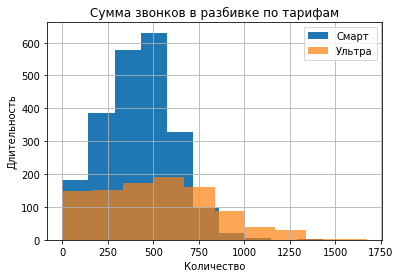

In [42]:
# строим гистограмму
smart_call_sum = df_total_call_month_sum.query("tariff == 'smart'")
ultra_call_sum = df_total_call_month_sum.query("tariff == 'ultra'")

smart_call_sum['sum_duration'].plot(kind='hist', alpha=1, grid=True)
ultra_call_sum['sum_duration'].plot(kind='hist', alpha=0.7, grid=True)
plt.xlabel('Количество')
plt.ylabel('Длительность')
plt.title('Сумма звонков в разбивке по тарифам')
plt.legend(['Смарт','Ультра'])
plt.show()

В среднем по тарифу Ультра используется 650 минут в месяц, по тарифу Смарт - 500 минут.

In [43]:
#аналогично по смс
df_total_mess_month_sum = df_total.groupby(['user_id', 'month','tariff']).agg({'count_sms':'sum'})

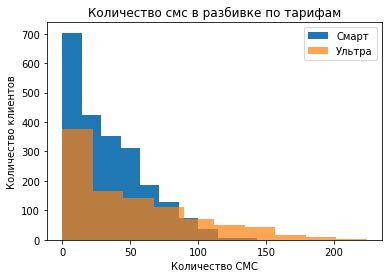

In [44]:
smart_mess = df_total_mess_month_sum.query("tariff == 'smart'")
ultra_mess = df_total_mess_month_sum.query("tariff == 'ultra'")

smart_mess['count_sms'].plot(kind='hist', alpha=1)
ultra_mess['count_sms'].plot(kind='hist', alpha=0.7)
plt.xlabel('Количество СМС')
plt.ylabel('Количество клиентов')
plt.title('Количество смс в разбивке по тарифам')
plt.legend(['Смарт','Ультра'])
plt.show()

Большинство пользователей тарифа Смарт отправляют ежемесячно не более 20 смс, тарифа Ультра - не более 50 смс.


In [45]:
#сумма интернет-трафика
df_total_inter_month_sum = df_total.groupby(['user_id','month','tariff']).agg({'gb_used':'sum'})

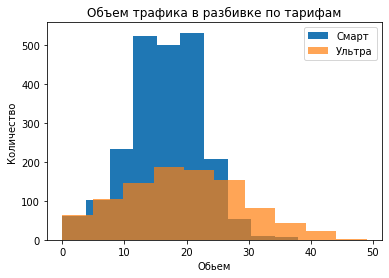

In [46]:
smart_inter = df_total_inter_month_sum.query("tariff == 'smart'")
ultra_inter = df_total_inter_month_sum.query("tariff == 'ultra'")

smart_inter['gb_used'].plot(kind='hist', alpha=1)
ultra_inter['gb_used'].plot(kind='hist', alpha=0.7)
plt.xlabel('Обьем')
plt.ylabel('Количество')
plt.title('Объем трафика в разбивке по тарифам')
plt.legend(['Смарт','Ультра'])
plt.show()

В среднем, пользователи тарифа Смарт тратят ежемесячно от 12 до 22 ГБ интернета, пользователи тарифа Ультра - от 15 и до 30 ГБ.

In [47]:
# Посчитаем среднее количество, дисперсию и стандартное отклонение
total_var_std = df_total.groupby(['tariff']).agg({'sum_duration':['mean','median','var', 'std'], 'count_sms':['mean','median','var', 'std'], 'gb_used':['mean','median','var', 'std']}).reset_index()

In [48]:
display(total_var_std)

tariff sum_duration                                    count_sms         \
                 mean median            var         std       mean median   
0  smart   417.934948  422.0   36219.315784  190.313730  33.384029   28.0   
1  ultra   526.623350  518.0  100873.633397  317.606098  49.363452   38.0   

                             gb_used                              
           var        std       mean median        var       std  
0   796.812958  28.227876  16.359354     17  33.160304  5.758498  
1  2285.266143  47.804457  19.525888     19  97.334949  9.865848

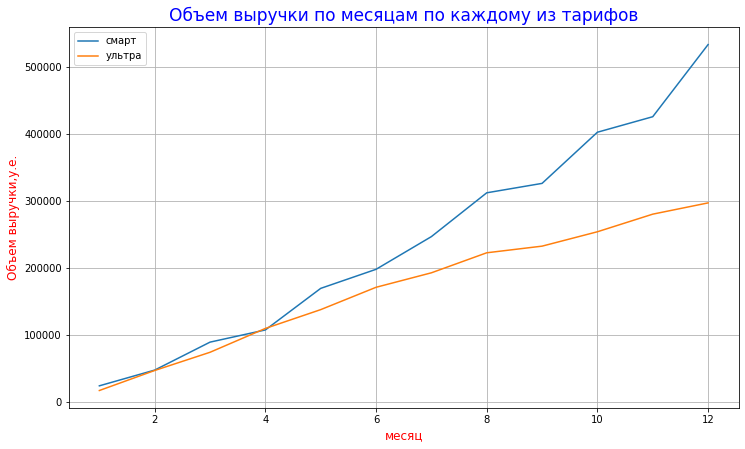

In [49]:
#посчитаем общую выручку помесячно
call_month_bill = df_total.groupby(['month','tariff']).agg({'total_bill':'sum'}).reset_index()
smart_bill_sum = call_month_bill.query("tariff == 'smart'")
ultra_bill_sum = call_month_bill.query("tariff == 'ultra'")

plt.figure(figsize=(12, 7))
plt.plot(smart_bill_sum ['month'], smart_bill_sum ['total_bill'],label='смарт')
plt.plot(ultra_bill_sum ['month'], ultra_bill_sum ['total_bill'],label='ультра')
plt.title('Объем выручки по месяцам по каждому из тарифов', fontsize=17, color='blue')
plt.xlabel('месяц',fontsize=12, color='red')
plt.ylabel('Объем выручки,у.е.',fontsize=12, color='red')
plt.grid(True)
plt.legend()
plt.show()


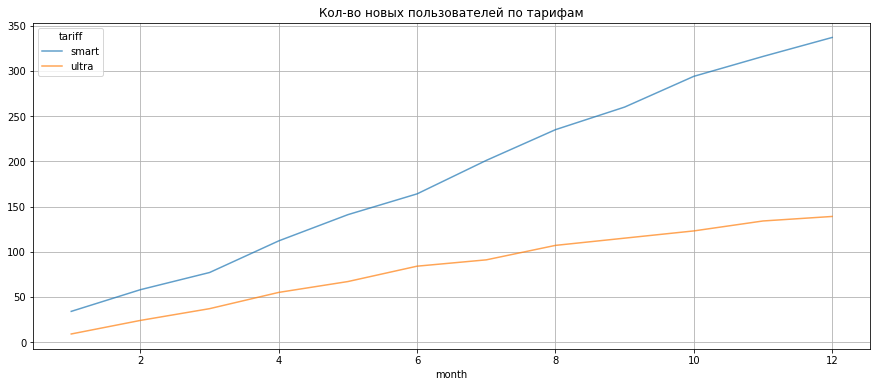

In [50]:
# Динамика подключивщихся пользователей по месяцам
df_total.pivot_table(
    index='month', 
    values='user_id', 
    columns='tariff', 
    aggfunc='count').plot(alpha=0.7, grid=True, figsize=(15, 6), title ='Кол-во новых пользователей по тарифам')
plt.show()


In [51]:
#Считаем доход с каждого клиента помесячно для каждого из тарифов
dinamic_total_bill=df_total.pivot_table(index='month', values='total_bill', columns='tariff', aggfunc=sum)
dinamic_user_id = df_total.pivot_table(index='month', values='user_id', columns='tariff', aggfunc='count')
dinamic_total = dinamic_total_bill.reset_index().merge(dinamic_user_id, on=['month'], how='left')
"""склеиваем таблицы с общей выручкой по месяцам с количеством подключившихся пользователей"""

"""Делим общую выручку на количество пользователей помесячно узнаем сколько в месяц принес один пользователь с разных тарифов"""
dinamic_total['profit_smart_user'] = dinamic_total['smart_x']/dinamic_total['smart_y']
dinamic_total['profit_ultra_user'] = dinamic_total['ultra_x']/dinamic_total['ultra_y']
dinamic_total = dinamic_total.rename(columns={'smart_x':'profit_smart_month','ultra_x':'profit_ultra_month','smart_y':'sum_user_smart', 'ultra_y': 'sum_user_ultra'})

In [52]:
dinamic_total.head()

tariff,month,profit_smart_month,profit_ultra_month,sum_user_smart,sum_user_ultra,profit_smart_user,profit_ultra_user
0,1,24525.0,17550.0,34,9,721.323529,1950.000000
1,2,48001.0,47400.0,58,24,827.603448,1975.000000
2,3,89676.0,74550.0,77,37,1164.623377,2014.864865
3,4,107866.0,110100.0,112,55,963.089286,2001.818182
4,5,169849.0,138150.0,141,67,1204.602837,2061.940299


In [53]:
print('Выручка за год с тарифа Смарт -  {:.0f} руб. '.format(dinamic_total['profit_smart_month'].sum()))
print('Выручка за год с тарифа Ультра - {:.0f} руб. '.format(dinamic_total['profit_ultra_month'].sum()))
print('________________________________________________________________')
print()
print('Средняя выручка за год с тарифа Смарт -  {:.0f} руб. '.format(dinamic_total['profit_smart_month'].mean()))
print('Средняя выручка за год с тарифа Ультра - {:.0f} руб. '.format(dinamic_total['profit_ultra_month'].mean()))
print('________________________________________________________________')
print()
print('Выручка за год с одного абонента тарифа Смарт -  {:.0f} руб. '.format(dinamic_total['profit_smart_user'].sum()))
print('Выручка за год с одного абонента тарифа Ультра - {:.0f} руб. '.format(dinamic_total['profit_ultra_user'].sum()))
print('________________________________________________________________')
print()
print('Средняя выручка за год с одного абонента тарифа Смарт -  {:.0f} руб. '.format(dinamic_total['profit_smart_user'].mean()))
print('Средняя выручка за год с одного абонента тарифа Ультра - {:.0f} руб. '.format(dinamic_total['profit_ultra_user'].mean()))

Выручка за год с тарифа Смарт -  2885751 руб. 
Выручка за год с тарифа Ультра - 2040000 руб. 
________________________________________________________________

Средняя выручка за год с тарифа Смарт -  240479 руб. 
Средняя выручка за год с тарифа Ультра - 170000 руб. 
________________________________________________________________

Выручка за год с одного абонента тарифа Смарт -  14203 руб. 
Выручка за год с одного абонента тарифа Ультра - 24573 руб. 
________________________________________________________________

Средняя выручка за год с одного абонента тарифа Смарт -  1184 руб. 
Средняя выручка за год с одного абонента тарифа Ультра - 2048 руб. 


### Вывод: <a id="4.1"></a>

Исходя из средних значений и медиан можно сделать следующие выводы:    

В среднем по тарифу Ультра используется 650 минут в месяц,что почти на 30% больше, чем по тарифу Смарт - 500 минут.
Большинство пользователей тарифа Смарт отправляют ежемесячно не более 20 смс, тарифа Ультра - не более 50 смс (почти в 2,5 раза больше). По объему интернет-трафика в тарифе Смарт используется  от 12 до 22 ГБ интернета ежемесячно, в тарифе Ультра - от 15 и до 30 ГБ.
Средние и медианы отличаются не очень сильно , что говорит об отсутствии большого количества выбросов
По стандартному отклонению мы видим большое отклонение от среднего во всех наших выборках, что возможно говорит об ежемесячном приросте клиентской базы.  

По диаграммам можно сделать выводы:

- Звонки:  

Наиболее распостранена длительность на тарифе "Смарт" 450-500 минут разговоров в месяц и в случае тарифа "Ультра" наибольшая длительность очень растянута и достигает от 250 - 800 минут достигая небольшого пика в 650 мин. На тарифе "Ультра клиенты раговаривают дольше чем на "Смарте".  

- СМС:  

В основном клиенты отправляют не очень большшое количество смс для обоих тарифов это до 50 в месяц
На тарифе "Ультра" есть небоьшое количество клиентов отправляющие более 150 смс.  

- Потребляемый интеренет траффик:  

Максимальное количество потребляемого трафика на тарифе "Ультра" гораздо выше.  

По графику прироста абонентов мы видим как компания в течении года наращивала базу абонентов. Прирост клиентов на тарифе смарт больше, скорее всего из-за более доступной цены. 
Не смотря на то, что стоимость тарифа Ультра выше, общая выручка с него меньше за счет меньшего количества абонентов. Абонент тарифа Ультра ежемесячно и всего в год приносит выручки больше чем абонент тарифа Смарт. Годовая выручка с одного абонента тарифа Ультра почти в 2 раза больше чем с абонента тарифа Смарт.

## Проверка гипотез <a id="5"></a>

Проверяем гипотезу, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается. Формируем нулевую и альтернативную гипотезу.Так как нулевая гипотеза всегда содержит знак равенства, то сформулируем ее следующим образом: Средняя выручка пользователей тарифов «Ультра» и «Смарт» равны. Исходя из нулевой гипотезы, альтернативная гипотеза будет звучать так: Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается. Критический уровень статистической значимости alpha = .05. 

Н0: Средняя выручка пользователей тарифов «Ультра» и «Смарт» равны.  

Н1: Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

In [54]:
#Выделяем из общей таблицы среднюю выручку пользователей тарифа Ультра
df_gipoteza_mean_bill_ultra = df_total[df_total['tariff'] == 'ultra']

df_gipoteza_mean_bill_ultra = df_gipoteza_mean_bill_ultra['total_bill']
display(df_gipoteza_mean_bill_ultra.mean())

2071.0659898477156

In [55]:
#Выделяем из общей таблицы среднюю выручку пользователей тарифа Смарт
df_gipoteza_mean_bill_smart = df_total[df_total['tariff'] == 'smart']
df_gipoteza_mean_bill_smart = df_gipoteza_mean_bill_smart['total_bill']
display(df_gipoteza_mean_bill_smart.mean())

1294.6393001345896

In [56]:
#interested_value = 1295 # предполагаемое среднее 
    
#results = st.ttest_1samp(
#    df_gipoteza_mean_bill_ultra, 
#    interested_value)
    
#print('p-значение: ', results.pvalue)
    
#if (results.pvalue < alpha):
#    print("Отвергаем нулевую гипотезу")
#else:
#    print("Не получилось отвергнуть нулевую гипотезу")

In [57]:
#Используем Гипотезу о равенстве средних двух генеральных совокупностей

alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    df_gipoteza_mean_bill_ultra, 
    df_gipoteza_mean_bill_smart)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.9776448000521676e-158
Отвергаем нулевую гипотезу


Проверим двухстороннюю гипотезу о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается. Воспользуемся выборкой из 100 элементов.

In [58]:
df_gipoteza_mean_bill_smart_100 = df_gipoteza_mean_bill_smart[1 : 101]
df_gipoteza_mean_bill_ultra_100 = df_gipoteza_mean_bill_ultra[75:176]

In [59]:
alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    df_gipoteza_mean_bill_ultra_100, 
    df_gipoteza_mean_bill_smart_100)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.3784489632863777e-15
Отвергаем нулевую гипотезу


По второй гипотезе о том, что средняя выручка пользователей из Москвы отличается от средней выручки пользователей из регионов, аналогично сформулируем нулевую и альтернативную гипотезу.  

Н0:Средняя выручка пользователей из Москвы равна от выручки пользователей из других регионов.  

Н1:Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [60]:
#формируем таблицы жителей из Москвы и из регионов
df_gipoteza_city_msk = df_total[df_total['city'] == 'Москва']
df_gipoteza_city_msk = df_gipoteza_city_msk['total_bill']

df_gipoteza_city_not_msk = df_total[df_total['city'] != 'Москва']
df_gipoteza_city_not_msk = df_gipoteza_city_not_msk['total_bill']

In [61]:
alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    df_gipoteza_city_msk, 
    df_gipoteza_city_not_msk)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.531666503831252
Не получилось отвергнуть нулевую гипотезу


Гипотеза возможно имеет место быть подтвержденной.

##  ОБЩИЙ ВЫВОД <a id="6"></a>

В среднем по тарифу Ультра используется 650 минут в месяц,что почти на 30% больше, чем по тарифу Смарт - 500 минут.
Большинство пользователей тарифа Смарт отправляют ежемесячно не более 20 смс, тарифа Ультра - не более 50 смс (почти в 2,5 раза больше). По объему интернет-трафика в тарифе Смарт используется  от 12 до 22 ГБ интернета ежемесячно, в тарифе Ультра - от 15 и до 30 ГБ.  

Наиболее распостранена длительность на тарифе "Смарт" 450-500 минут разговоров в месяц и в случае тарифа "Ультра" наибольшая длительность очень растянута и достигает от 250 - 800 минут достигая небольшого пика в 650 мин. На тарифе "Ультра клиенты раговаривают дольше чем на "Смарте".  

В основном клиенты отправляют не очень большшое количество смс для обоих тарифов это до 50 в месяц
На тарифе "Ультра" есть небоьшое количество клиентов отправляющие более 150 смс.  

Максимальное количество потребляемого трафика на тарифе "Ультра" гораздо выше.  

По графику прироста абонентов мы видим как компания в течении года наращивала базу абонентов. Прирост клиентов на тарифе смарт больше, скорее всего из-за более доступной цены. 
Не смотря на то, что стоимость тарифа Ультра выше, общая выручка с него меньше за счет меньшего количества абонентов. Абонент тарифа Ультра ежемесячно и всего в год приносит выручки больше чем абонент тарифа Смарт. Годовая выручка с одного абонента тарифа Ультра почти в 2 раза больше чем с абонента тарифа Смарт.  

При проверке гипотез получились следующие результаты:  
Гипотеза о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается - подтвердилась.  
Гипотеза о том, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов - не подтвердилась.
Оба тарифа приносят прибыль, в расчете на одного клиента прибыль тарифа Ультра выше, но валовую выручку больше приносит тариф смарт.




### Рекомендации <a id="6.1"></a>

- Тарифы, исходя из разницы количества пользователей, используют абоненты разных целевых аудиторий, например с разным уровнем дохода. Не целесообразно закрывать ни один из тарифов.  
- Судя по расходуемому объему интернет-трафика, в целях привлечения новых клиентов, возможно необходимо увеличения пакетного трафика до 20 и 35 ГБ в тарифах Смарт и Ультра, соответственно.  
- Судя по велечине средней выручки в Москве и регионах, рекомендуется углубить экспансию в регионы, которые в среднем приносят сравнимую с Москвой прибыль.  
- Вероятно излишнее количество пакетных минут и СМС на тарифе Ультра необходимо уменьшить, так как данное уменьшение не принесет вреда текущим пользователям.